# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [22]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## CIFAR-10 Data Loading and Preprocessing

In [23]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print 'Training data shape: ', X_train.shape
print 'Training labels shape: ', y_train.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Training data shape:  (50000L, 32L, 32L, 3L)
Training labels shape:  (50000L,)
Test data shape:  (10000L, 32L, 32L, 3L)
Test labels shape:  (10000L,)


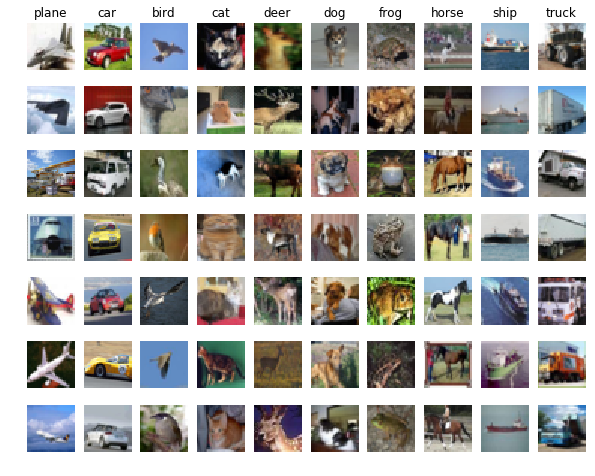

In [24]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [25]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set验证集 will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Train data shape:  (49000L, 32L, 32L, 3L)
Train labels shape:  (49000L,)
Validation data shape:  (1000L, 32L, 32L, 3L)
Validation labels shape:  (1000L,)
Test data shape:  (1000L, 32L, 32L, 3L)
Test labels shape:  (1000L,)


In [26]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print 'Training data shape: ', X_train.shape
print 'Validation data shape: ', X_val.shape
print 'Test data shape: ', X_test.shape
print 'dev data shape: ', X_dev.shape

Training data shape:  (49000L, 3072L)
Validation data shape:  (1000L, 3072L)
Test data shape:  (1000L, 3072L)
dev data shape:  (500L, 3072L)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


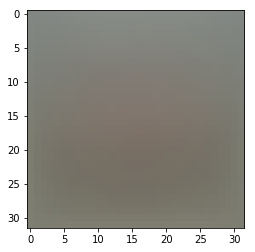

In [27]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)#32*32*3，以行来求平均
print mean_image[:10] # print a few of the elements,
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [28]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.#把偏差矩阵加在矩阵后面
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])#hstack是将列向量合并
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print X_train.shape, X_val.shape, X_test.shape, X_dev.shape

(49000L, 3073L) (1000L, 3073L) (1000L, 3073L) (500L, 3073L)


In [31]:
X_train

array([[ 59.,  62.,  63., ...,  92.,  72.,   1.],
       [154., 177., 187., ..., 133., 144.,   1.],
       [255., 255., 255., ...,  86.,  84.,   1.],
       ...,
       [ 61.,  73.,  76., ..., 160., 117.,   1.],
       [ 10.,   4.,  14., ..., 174., 205.,   1.],
       [175., 193., 229., ...,  78.,  90.,   1.]])

## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [93]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.00001)
print 'loss: %f' % (loss, )
y_dev

loss: 9.437977


array([1, 9, 3, 4, 1, 4, 8, 1, 4, 4, 4, 0, 1, 7, 4, 5, 4, 6, 5, 3, 6, 2,
       9, 9, 4, 3, 9, 8, 7, 7, 1, 8, 0, 2, 3, 2, 6, 9, 3, 1, 8, 0, 3, 3,
       7, 1, 2, 4, 7, 1, 7, 3, 9, 5, 7, 3, 7, 9, 6, 8, 3, 9, 2, 1, 5, 6,
       7, 2, 2, 4, 7, 8, 7, 4, 4, 4, 4, 4, 7, 5, 2, 3, 3, 4, 2, 7, 0, 7,
       7, 8, 5, 9, 8, 9, 8, 0, 3, 1, 1, 5, 0, 4, 2, 4, 1, 4, 9, 9, 4, 2,
       3, 6, 1, 8, 7, 2, 1, 7, 1, 3, 8, 3, 9, 0, 3, 8, 4, 3, 5, 9, 6, 4,
       0, 8, 1, 6, 0, 7, 5, 1, 4, 6, 8, 1, 0, 1, 6, 8, 3, 4, 1, 9, 2, 7,
       0, 0, 4, 5, 6, 0, 1, 7, 5, 5, 8, 0, 2, 9, 7, 5, 7, 2, 9, 1, 0, 5,
       4, 3, 5, 9, 7, 7, 4, 8, 4, 5, 1, 9, 2, 5, 9, 5, 1, 6, 7, 4, 5, 9,
       5, 6, 1, 7, 7, 2, 4, 8, 3, 9, 1, 0, 2, 9, 0, 0, 6, 6, 2, 5, 5, 1,
       4, 3, 3, 1, 0, 6, 4, 5, 2, 3, 0, 5, 2, 0, 0, 1, 4, 4, 6, 0, 4, 6,
       1, 1, 9, 7, 2, 7, 1, 6, 4, 1, 3, 6, 8, 5, 0, 1, 3, 7, 8, 2, 9, 3,
       7, 9, 1, 6, 1, 6, 0, 4, 9, 5, 8, 8, 7, 3, 9, 8, 6, 8, 5, 3, 5, 5,
       7, 8, 5, 6, 8, 2, 4, 7, 0, 2, 2, 9, 7, 8, 2,

The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [75]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 18.822200 analytic: 9317.000000, relative error: 9.959677e-01
numerical: 81.122000 analytic: 40561.000000, relative error: 9.960080e-01
numerical: -1.826000 analytic: -913.000000, relative error: 9.960080e-01
numerical: -7.904000 analytic: -3952.000000, relative error: 9.960080e-01
numerical: 84.300000 analytic: 42150.000000, relative error: 9.960080e-01
numerical: 64.962000 analytic: 32481.000000, relative error: 9.960080e-01
numerical: -20.933937 analytic: -10537.000000, relative error: 9.960345e-01
numerical: -13.222000 analytic: -6611.000000, relative error: 9.960080e-01
numerical: -6.286146 analytic: -3097.000000, relative error: 9.959487e-01
numerical: -28.312146 analytic: -14162.000000, relative error: 9.960097e-01
numerical: 87.125632 analytic: 43561.000000, relative error: 9.960078e-01
numerical: 5.245897 analytic: 2624.000000, relative error: 9.960096e-01
numerical: -71.420713 analytic: -35710.000000, relative error: 9.960079e-01
numerical: 63.195784 analytic: 3160

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *fill this in.*

In [110]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized,_ = svm_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()

Naive loss: 9.437977e+00 computed in 0.103000s


In [111]:
print 'Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# The losses should match but your vectorized implementation should be much faster.
print 'difference: %f' % (loss_naive - loss_vectorized)

Vectorized loss: 9.437977e+00 computed in 0.005000s
difference: 0.000000


In [116]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
lose_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Naive loss and gradient: computed in %fs' % (toc - tic)

tic = time.time()
loss_vectorized, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Vectorized loss and gradient: computed in %fs' % (toc - tic)

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.

difference = np.linalg.norm(loss_naive - loss_vectorized)
print 'difference: %f' % difference

Naive loss and gradient: computed in 0.113000s
Vectorized loss and gradient: computed in 0.005000s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [118]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print 'That took %fs' % (toc - tic)

iteration 0 / 1500: loss 811.928986
iteration 100 / 1500: loss 287.737052
iteration 200 / 1500: loss 109.031685
iteration 300 / 1500: loss 43.675165
iteration 400 / 1500: loss 21.847799
iteration 500 / 1500: loss 12.889172
iteration 600 / 1500: loss 11.399689
iteration 700 / 1500: loss 7.744486
iteration 800 / 1500: loss 9.090579
iteration 900 / 1500: loss 7.507580
iteration 1000 / 1500: loss 8.323168
iteration 1100 / 1500: loss 9.111620
iteration 1200 / 1500: loss 7.398107
iteration 1300 / 1500: loss 9.052284
iteration 1400 / 1500: loss 9.227237
That took 9.830000s


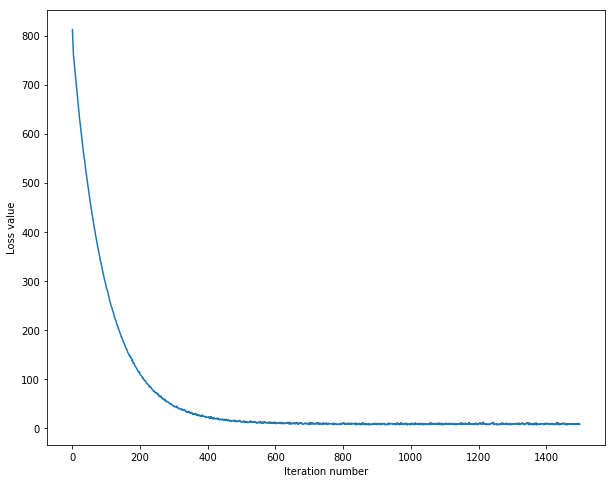

In [119]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [121]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print 'training accuracy: %f' % (np.mean(y_train == y_train_pred), )
y_val_pred = svm.predict(X_val)
print 'validation accuracy: %f' % (np.mean(y_val == y_val_pred), )

training accuracy: 0.234714
validation accuracy: 0.257000


In [122]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-7, 5e-5]
regularization_strengths = [5e4, 1e5]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
pass
for lr in learning_rates:
    for rs in regularization_strengths:
        svm = LinearSVM()
        loss_hist = svm.train(X_train, y_train, learning_rate=lr, reg=rs,
                      num_iters=1500, verbose=True)
        y_train_pred = svm.predict(X_train)
        train_acc = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val)
        val_acc = np.mean(y_val == y_val_pred)
        
        results[(lr, rs)] = (train_acc, val_acc)
        
        if val_acc > best_val:
            best_val = val_acc
            best_svm = svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

iteration 0 / 1500: loss 798.907684
iteration 100 / 1500: loss 286.473088
iteration 200 / 1500: loss 110.834990
iteration 300 / 1500: loss 46.012631
iteration 400 / 1500: loss 22.491179
iteration 500 / 1500: loss 13.609708
iteration 600 / 1500: loss 9.477938
iteration 700 / 1500: loss 9.926452
iteration 800 / 1500: loss 8.511890
iteration 900 / 1500: loss 9.233118
iteration 1000 / 1500: loss 8.083958
iteration 1100 / 1500: loss 7.791072
iteration 1200 / 1500: loss 7.608425
iteration 1300 / 1500: loss 7.083067
iteration 1400 / 1500: loss 7.192516
iteration 0 / 1500: loss 1575.330389
iteration 100 / 1500: loss 212.381725
iteration 200 / 1500: loss 37.891072
iteration 300 / 1500: loss 12.926550
iteration 400 / 1500: loss 11.239860
iteration 500 / 1500: loss 10.058837
iteration 600 / 1500: loss 8.848448
iteration 700 / 1500: loss 8.013989
iteration 800 / 1500: loss 10.959376
iteration 900 / 1500: loss 8.103323
iteration 1000 / 1500: loss 8.820201
iteration 1100 / 1500: loss 8.531010
iterat

cs231n\classifiers\linear_svm.py:84: RuntimeWarning: overflow encountered in double_scalars
  loss += 0.5 * reg * np.sum(W * W)
E:\anaconda3\anaconda3\envs\py2\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
cs231n\classifiers\linear_svm.py:84: RuntimeWarning: overflow encountered in multiply
  loss += 0.5 * reg * np.sum(W * W)


iteration 900 / 1500: loss inf
iteration 1000 / 1500: loss inf
iteration 1100 / 1500: loss inf
iteration 1200 / 1500: loss inf
iteration 1300 / 1500: loss inf
iteration 1400 / 1500: loss inf
iteration 0 / 1500: loss 1582.578714
iteration 100 / 1500: loss 8289909411656676468396627300787432186157963130769363899640770763243303713194190015921074784256941531524814228255282466652160.000000
iteration 200 / 1500: loss 21406617567601968923745074124641492580485143045949231324282352123998870543067608583102200582993998814588957728559158646809231509180811591224817420444004712837865156807882825040163048685845469553219761081366604714094882258724231266090950496092160.000000
iteration 300 / 1500: loss inf
iteration 400 / 1500: loss inf
iteration 500 / 1500: loss inf


cs231n\classifiers\linear_svm.py:80: RuntimeWarning: overflow encountered in subtract
  margin=scores-scorescorrect+1#500*10s
cs231n\classifiers\linear_svm.py:80: RuntimeWarning: invalid value encountered in subtract
  margin=scores-scorescorrect+1#500*10s
cs231n\classifiers\linear_svm.py:81: RuntimeWarning: invalid value encountered in maximum
  margin=np.maximum(0,margin)
cs231n\classifiers\linear_svm.py:100: RuntimeWarning: invalid value encountered in greater
  margin[margin>0]=1
cs231n\classifiers\linear_svm.py:103: RuntimeWarning: overflow encountered in multiply
  dW+=np.dot(X.T,margin)/num_train+reg*W


iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.228327 val accuracy: 0.244000
lr 1.000000e-07 reg 1.000000e+05 train accuracy: 0.248429 val accuracy: 0.226000
lr 5.000000e-05 reg 5.000000e+04 train accuracy: 0.100449 val accuracy: 0.078000
lr 5.000000e-05 reg 1.000000e+05 train accuracy: 0.100265 val accuracy: 0.087000
best validation accuracy achieved during cross-validation: 0.244000


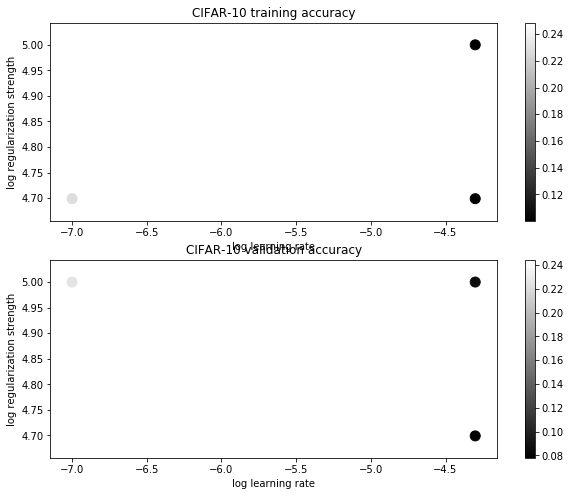

In [123]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [124]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'linear SVM on raw pixels final test set accuracy: %f' % test_accuracy

linear SVM on raw pixels final test set accuracy: 0.224000


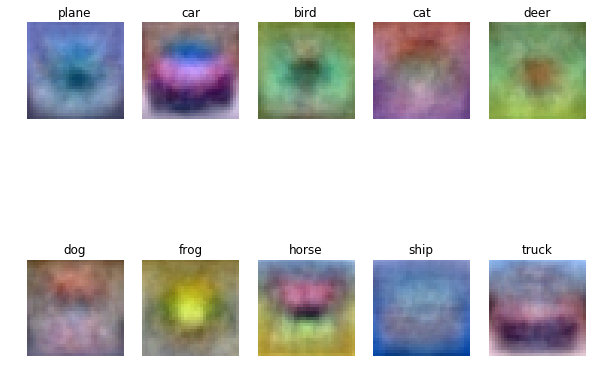

In [125]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
    
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *fill this in*
从图像可以看出，权重是用于对原图像进行特征提取的工具，与原图像关系很大。很朴素的思想，在分类器权重向量上，投影最大的向量得分应该最高，训练样本得到的权重向量，最好的结果就是训练样本提取出来的共性的方向，类似于一种模板或者过滤器。